In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from matplotlib import cm
import matplotlib.cm as cmx
import matplotlib.colors as colors
plt.rcParams["font.sans-serif"] = "Arial"

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.autolayout'] = True

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'
plt.rcParams['font.size'] = 8
import datetime as dt

import matplotlib as mpl
%matplotlib inline


In [2]:
#read in isotope data
df = pd.read_csv('../Data/isotope-data.csv',
                 sep=',',  skiprows = [1])
df['Time Collected'] = df['Time Collected'].fillna('12:00')
df['datetime'] = pd.to_datetime(df['Date Collected']+ ' ' + df['Time Collected'])
df['date'] = pd.to_datetime(df['Date Collected'])
df['edgecolors']='grey'
df.loc[df['Energetic State'] == 'saturated', 'edgecolors'] = 'gold'
df['dD']=df['dD'].astype(float)
df['dO']=df['dO'].astype(float)

#Read in rainfall data
precip = pd.read_csv('../Data/rain.csv')
precip.head()
precip.index= pd.to_datetime(precip['LocalDateTime'])                  

#'DataValue' is in units of mm
precip['waterYear']=np.where(~precip.index.month.isin([10,11,12]), 
                             precip.index.year, precip.index.year+1)
precip['WY_Rain']=precip.groupby('waterYear')['DataValue'].cumsum()
precip['runningCumulative']=precip['DataValue'].cumsum()


In [3]:
sagehornGW = df[df['Sample Type II']=='Well water']
dry = df[df['Sample Type II']=='Stream water']

In [4]:
sagehornRain = df[df['Sample Type II']=='Rain']
sagehornRain.sort_values('datetime',inplace=True)

/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
#find closest indices in the rainfall record that correspond to when isotope values where collected
indices = precip.index.searchsorted(sagehornRain['datetime'].values)

sagehornRain['cumulativeRain_mm'] = precip.iloc[indices]['runningCumulative'].values-1
sagehornRain['previousRain_mm'] = sagehornRain['cumulativeRain_mm'] - sagehornRain['cumulativeRain_mm'].shift(+1)
sagehornRain['previousRain_mm'].iloc[0]=20


/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://panda

In [6]:
#weighted precipitation by storm amount
weightedAverage_dD = np.average(sagehornRain.dD, weights=sagehornRain.previousRain_mm)
weightedAverage_dO = np.average(sagehornRain.dO, weights=sagehornRain.previousRain_mm)
print('dD weighted average: ' + str(weightedAverage_dD))
print('dO weighted average: ' + str(weightedAverage_dO))

dD weighted average: -48.48524167837841
dO weighted average: -7.971057206439419


In [7]:
dD_new = []
dO_new = []
dD_old = sagehornRain['dD'].values
dO_old = sagehornRain['dO'].values
sagehornRain['Integer_Storm_Precip_mm'] = sagehornRain['previousRain_mm'].astype(int)
weights = sagehornRain['Integer_Storm_Precip_mm'].values

for isotope, weight in zip(dD_old, weights):
    for i in range(weight):
        dD_new.append(isotope)
for isotope, weight in zip(dO_old, weights):
    for i in range(weight):
        dO_new.append(isotope)


/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
std_dD = np.std(dD_new)
std_dO = np.std(dO_new)

In [9]:
slope = std_dD / std_dO
intercept = weightedAverage_dD - (slope * weightedAverage_dO)
xs = np.arange(-50.0,50.0)

ys = (slope*xs)+intercept

In [10]:
print(slope, intercept)

8.252831328557294 17.298548956647217


In [11]:
sagehorn = df[df['Site']=='Sagehorn']
sagehorn['day'] = sagehorn['datetime'].dt.date

sagehorn['day'].replace({dt.date(2015, 8, 3): dt.date(2015, 8, 4)}, regex=True, inplace=True)
sagehorn['day'].replace({dt.date(2015, 9, 27): dt.date(2015, 9, 28)}, regex=True, inplace=True)
sagehorn['Well water level (m)'].replace({'>2': '2'}, regex=True, inplace=True)



In [12]:
sagehorn['Well water level (m)'] = pd.to_numeric(sagehorn['Well water level (m)'],errors='coerce')

In [13]:
sagehornOaks = sagehorn[sagehorn['Species (scientific)']=='QUGA']
sagehornOaks = sagehornOaks[sagehornOaks['datetime'] > pd.to_datetime('2015-01-01 00:00:00')]



drilled = sagehorn[(sagehorn['Sample Type II']=='Drilled material')]
drilled['Depth (cm)'] = drilled['Depth (cm)'].astype(float)



/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
GWweightedAverage_dD = np.average(sagehornGW.dD)
GWweightedAverage_dO = np.average(sagehornGW.dO)
DryweightedAverage_dD = np.average(dry.dD)
DryweightedAverage_dO = np.average(dry.dO)

/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: covariance is not positive-semidefinite.


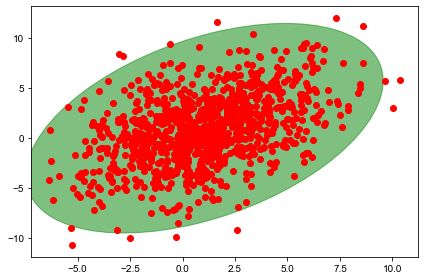

In [15]:
# plot an ellipse. this code was sourced from a snippet on stackexchange

from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, zorder=-200,**kwargs)

    ax.add_artist(ellip)
    return ellip

if __name__ == '__main__':
    #-- Example usage -----------------------
    # Generate some random, correlated data
    points = np.random.multivariate_normal(
            mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000
            )
    # Plot the raw points...
    x, y = points.T
    plt.plot(x, y, 'ro')

    # Plot a transparent 3 standard deviation covariance ellipse
    plot_point_cov(points, nstd=3, alpha=0.5, color='green')

/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


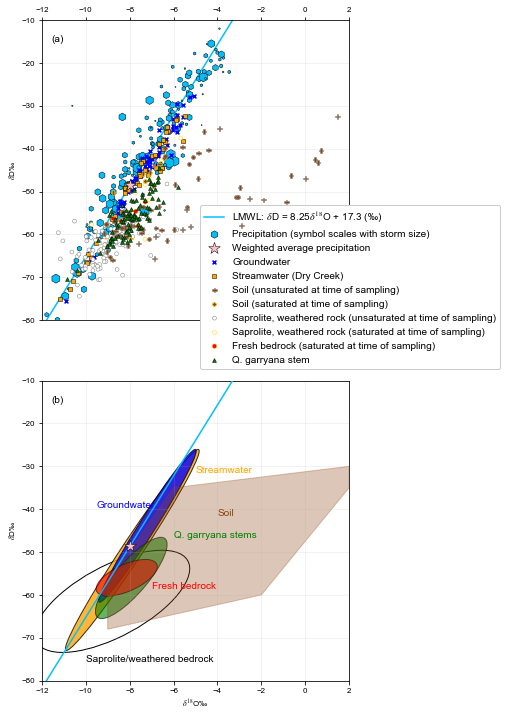

In [16]:
## MANUSCRIPT FIGURE 

### DOUBLE PLOT - NEW COLOR SCALE
### OAKS STEMS, DRILLED MATERIAL, GROUNDWATER, STREAMS, 
soil_color = 'saddlebrown'
soil_marker = 'P'


plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(2, sharex=True,figsize=(7,10))
plt.rcParams['font.size'] = 8

soil = drilled[drilled['Sample Type III'] == 'Soil'] 
sap_wxbedrock = drilled[(drilled['Sample Type III'] =='Saprolite') | 
                        (drilled['Sample Type III'] =='Weathered bedrock')] 
fresh_bedrock = drilled[drilled['Sample Type III'] == 'Fresh bedrock'] 
sagehornGW = sagehorn[sagehorn['Sample Type II'] == 'Well water']
sagehornGW = sagehornGW[  (sagehornGW['Location'] == 'MN1') | 
                          (sagehornGW['Location'] == 'MN-1')|
                          (sagehornGW['Location'] == 'MS4') |
                          (sagehornGW['Location'] == 'MS-4')|
                          (sagehornGW['Location'] == 'W507')]
dry = sagehorn[(sagehorn['Location'] == 'Dry Creek')]
dry = dry[dry.dO<=-2]

stems = sagehornOaks[sagehornOaks['Sample Type II']=='Stem']
stems = stems[stems.Location != 'T87']


aa = ax[0].scatter(sagehornRain['dO'], sagehornRain['dD'],
            label = 'Precipitation (symbol scales with storm size)',
            color = 'deepskyblue',
            edgecolor='black',
            linewidth=0.5,
            marker = 'h',
            s=sagehornRain['Integer_Storm_Precip_mm'].astype('float'), 
                   zorder=-100)

bb = ax[0].scatter(weightedAverage_dO, weightedAverage_dD,
            label = 'Weighted average precipitation',
            color = 'pink',
            edgecolor='black',
            linewidth='0.5',
            marker = '*',
            s=150, zorder=105)
cc= ax[0].scatter(sagehornGW['dO'], sagehornGW['dD'],
            label = 'Groundwater',
            color = 'blue',
            edgecolor = 'white',
                  s=15,
            marker = 'x')

dd= ax[0].plot(xs,ys, color='deepskyblue',
              label=r'LMWL: $\delta$D = %.2f' % slope + r'$\delta^{18}$O + %.1f ' % intercept + '(' + u'\u2030' + ')', 
              zorder=-200)

#DRY CREEK
ee = ax[0].scatter(dry['dO'], dry['dD'],
            label = 'Streamwater (Dry Creek)',
            color = 'orange',
            edgecolor = 'black',
                               linewidth='0.5',
            s=20,
            marker = 's')
ff = ax[0].scatter(soil['dO'].astype(float), soil['dD'].astype('float'),
            label = 'Soil (unsaturated at time of sampling)',
            color = soil_color,
            marker = soil_marker,
                   zorder=33,  
            edgecolor=soil['edgecolors'],
            linewidth=.5,
            s=20)
ff = ax[0].scatter(1000, 1000,
            label = 'Soil (saturated at time of sampling)',
            color = soil_color,
            marker = soil_marker,
            zorder=33,
            edgecolor='gold',
            linewidth=.5,
            s=20)

gg = ax[0].scatter(sap_wxbedrock['dO'], sap_wxbedrock['dD'],
            label = 'Saprolite, weathered rock (unsaturated at time of sampling)',
            color = 'white',
            edgecolor=sap_wxbedrock['edgecolors'].values,
            linewidth=.5,
            s=15)  

gg = ax[0].scatter(1000, 1000,
            label = 'Saprolite, weathered rock (saturated at time of sampling)',
            color = 'white',
            edgecolor='gold',
            linewidth=.5,
            s=15) 

ff = ax[0].scatter(fresh_bedrock['dO'], fresh_bedrock['dD'],
            label = 'Fresh bedrock (saturated at time of sampling)',
            color = 'red',
            edgecolor=fresh_bedrock['edgecolors'].values,
            linewidth=.5,
            s=20)  


ax[0].scatter(stems.dO,stems.dD, label = 'Q. garryana stem',
            color = 'green',
            edgecolor='black',
            marker = '^',
            linewidth='0.5',
            alpha=1,
            zorder=40,
            s=15)


#------------------SECOND PLOT ----------------
ax[1].set_xlabel(r'$\delta^{18}$O' + u'\u2030')

ax[1].set_ylabel(r'$\delta$D' + u'\u2030')
GW = sagehornGW.as_matrix(columns=['dO','dD'])
GW = GW[~np.isnan(GW).any(axis=1)]

x=[-9, -9, -6,   2,  2, -2]
y=[-68,-57,-35, -30,-35,-60]
ax[1].fill(x,y, color=soil_color, ec='black', alpha=0.3)
ax[1].text(-4, -40, 'Soil', 
           alpha=1,color=soil_color,verticalalignment='top', horizontalalignment='left',fontsize=10)

plot_point_cov(sap_wxbedrock.as_matrix(columns=['dO','dD']),ax=ax[1], 
               nstd=2, alpha=1, color='white', ec='black', lw=1)
ax[1].text(-10, -74, 'Saprolite/weathered bedrock', 
           color='black',verticalalignment='top', horizontalalignment='left',fontsize=10)


dryMatrix=dry.as_matrix(columns=['dO','dD'])
dryMatrix = dryMatrix[~np.isnan(dryMatrix).any(axis=1)]

plot_point_cov(dryMatrix, ax=ax[1], nstd=2, alpha=0.8, color='orange', ec='black', lw=1)
ax[1].text(-5, -30, 'Streamwater', color='orange',verticalalignment='top', horizontalalignment='left',fontsize=10)
plot_point_cov(GW, ax=ax[1], nstd=2, alpha=0.8, color='blue', ec='black', lw=1, label='Groundwater')
ax[1].text(-9.5, -38, 'Groundwater', color='blue',verticalalignment='top', horizontalalignment='left',fontsize=10)


plot_point_cov(stems.as_matrix(columns=['dO','dD']), ax=ax[1], nstd=2, alpha=0.6, color='green',ec='black', lw=1)
ax[1].text(-6, -45, 'Q. garryana stems', color='green',verticalalignment='top', horizontalalignment='left',fontsize=10)
plot_point_cov(fresh_bedrock.as_matrix(columns=['dO','dD']), ax=ax[1], nstd=2, alpha=0.6, color='red',ec='black', lw=1)


ax[1].text(-7, -57, 'Fresh bedrock', color='red',verticalalignment='top', horizontalalignment='left',fontsize=10)


ax[1].scatter(weightedAverage_dO, weightedAverage_dD,
            label = 'Weighted average precipitation',
            color = 'pink',
            edgecolor='black',
            linewidth='0.5',
            marker = '*',
            s=150, zorder=105)


#LMWL
ax[1].plot(xs,ys, label='LMWL', zorder=100, color='deepskyblue')


# --------


ax[1].set_xlabel(r'$\delta^{18}$O' + u'\u2030')

ax[1].grid(alpha=0.2)
ax[0].grid(alpha=0.2)

ax[0].text(0.03, 0.95, '(a)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[0].transAxes,
        color='black', fontsize=10)

ax[1].text(0.03, 0.95, '(b)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[1].transAxes,
        color='black', fontsize=10)

ax[0].xaxis.set_ticks_position('top')

ax[0].set_ylim([-80,-10])

ax[1].set_ylim([-80,-10])


ax[0].set_xlim([-12,2])

ax[1].set_ylabel(r'$\delta$D' + u'\u2030')
ax[0].set_ylabel(r'$\delta$D' + u'\u2030')

ax[0].legend(scatterpoints = 1, prop={'size':10}, bbox_to_anchor=(.5, .4), ncol=1,  facecolor="white", framealpha=1)
ax[0].set_zorder(1)
savedFile = '../Figs/DualIsotopes.pdf'
plt.savefig(savedFile, bbox_inches='tight')
#os.startfile(savedFile)
# plt.show()

/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


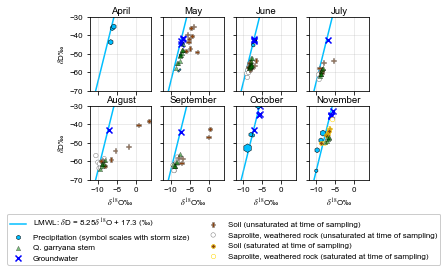

In [17]:
months = {4: 'April',5:'May',6:'June',7:'July',
          8:'August',9:'September',10:'October',11:'November'}
year = [2016]

fig,ax=plt.subplots(2,4,
                   sharex=True,sharey=True,
                   figsize=(5,3))

ax = ax.flatten()

ax[5].scatter(1000,1000,
        label = 'Precipitation (symbol scales with storm size)',
        color = 'deepskyblue',
        edgecolor='black',
        linewidth=0.5,
        zorder=2,

        marker = 'h',
        s=20)

    
for i,month in enumerate(months.keys()):
    
    # Major ticks every 20, minor ticks every 5
    major_ticks = [-10,-5,0]

    ax[i].set_xticks(major_ticks)
    ax[i].grid(alpha=.3,zorder=-1000)

    ax[i].set_title(months[month],y=.96)
    # STEMS
    plotData = stems[(stems.datetime.dt.month == month) &
                     (stems.datetime.dt.year.isin(year))]
    ax[i].scatter(plotData.dO,plotData.dD, label = 'Q. garryana stem',
            color = 'green',
            edgecolor='black',
            marker = '^',
            zorder=15,

            linewidth='0.5',
                  alpha=0.5,
            s=20)
    
#   RAIN
    plotData = sagehornRain[(sagehornRain.datetime.dt.month == month) &
                     (sagehornRain.datetime.dt.year.isin(year))]
    ax[i].scatter(plotData['dO'], plotData['dD'],
#             label = 'Precipitation',
            color = 'deepskyblue',
            edgecolor='black',
            linewidth=0.5,
            zorder=2,

            marker = 'h',
            s=plotData['Integer_Storm_Precip_mm'])

    # GROUNDWATER
    plotData = sagehornGW[(sagehornGW.datetime.dt.month == month) &
                     (sagehornGW.datetime.dt.year.isin(year))]
   
    ax[i].scatter(plotData['dO'], plotData['dD'],
            label = 'Groundwater',
            color = 'blue',
            edgecolor = 'white', 
            marker = 'x')
    #LMWL
    ax[i].plot(xs,ys, color='deepskyblue',
              label=r'LMWL: $\delta$D = %.2f' % slope + r'$\delta^{18}$O + %.1f ' % intercept + '(' + u'\u2030' + ')', 
              zorder=-200)

    #SOIL
    plotData = soil[(soil.datetime.dt.month == month) &
                     (soil.datetime.dt.year.isin(year))]
    
    ax[i].scatter(plotData['dO'].astype(float), plotData['dD'].astype('float'),
            label = 'Soil (unsaturated at time of sampling)',
            color = soil_color,   
            edgecolor=plotData['edgecolors'],
            linewidth=.5,
            marker=soil_marker,
            zorder=10,
            s=20)
    #SAP/WX BEDROCK
    plotData = sap_wxbedrock[(sap_wxbedrock.datetime.dt.month == month) &
                     (sap_wxbedrock.datetime.dt.year.isin(year))]
    
    ax[i].scatter(plotData['dO'], plotData['dD'],
            label = 'Saprolite, weathered rock (unsaturated at time of sampling)',
            color = 'white',  
            zorder=5,

            edgecolor=plotData['edgecolors'].values,
            linewidth=.5,
            s=20)  

ax[5].scatter(1000,1000,
        label = 'Soil (saturated at time of sampling)',
        color = soil_color,
        marker=soil_marker,
        edgecolor='gold',
        linewidth=.5,
        s=20)    
ax[5].scatter(1000,1000,
    label = 'Saprolite, weathered rock (saturated at time of sampling)',
    color = 'white',  

    edgecolor='gold',
    linewidth=.5,
    s=20)  
    
#   RAIN

ax[5].legend(ncol=2,fontsize=8, 
           scatterpoints = 1, 
           bbox_to_anchor=(1,-0.8), 
             loc='center',
           facecolor="white", framealpha=1)
plt.ylim(-70,-30)
plt.xlim(-12,4)
ax[0].set_ylabel(r'$\delta$D' + u'\u2030')
ax[4].set_ylabel(r'$\delta$D' + u'\u2030')
ax[4].set_xlabel(r'$\delta^{18}$O' + u'\u2030')
ax[5].set_xlabel(r'$\delta^{18}$O' + u'\u2030')
ax[6].set_xlabel(r'$\delta^{18}$O' + u'\u2030')
ax[7].set_xlabel(r'$\delta^{18}$O' + u'\u2030')

plt.tight_layout()

plt.savefig('../Figs/Timeseries-dualIsotopes_2016_new.pdf', 
            bbox_inches='tight', pad_inches=0)

